# load models

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from fastai.text import *

## load the data

In [4]:
import codecs
import pandas as pd

In [5]:
data_frame = {}
for i in ["train", "test"]:
    data = list(codecs.open("token_{}.tsv".format(i), 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    data_frame[i] = pd.DataFrame({"text": x, "label": y, "valid": i=="valid"})

msk = np.random.rand(len(data_frame["train"])) < 0.8
train = data_frame["train"][msk]
valid = data_frame["train"][~msk]
len(train), len(valid), len(data_frame["test"])

(8164, 2080, 2560)

In [6]:
dataframe = pd.concat([data_frame["train"], data_frame["test"]])

# 5000 word version

## language model

In [29]:
processor = [TokenizeProcessor(tokenizer=Tokenizer(lang='he')), NumericalizeProcessor(max_vocab=5000)]
data_lm = (TextList.from_df(dataframe, cols=["text"], processor=processor)
            .random_split_by_pct(0.2)
            .label_for_lm()           
            .databunch(bs=24))

In [31]:
len(data_lm.vocab.itos)
data_lm.show_batch()

idx,text
0,מדינת ישראל עם ישראל אוהב אותך xxunk ׳ ה אוהב אותך ואתה דוגמה ומופת לכל אדם באשר הוא אני מאחל לך אושר עושר ובריאות xxunk עד 120 ועוד xxbos אדוני הנשיא סליחה על xxunk תפסיק xxunk את השכל . עד היום לא xxunk ולו במילה על המצב במדינה . לא הבעת את xxunk לצבא . לא אמרת מילה טובה xxunk לתושבי הדרום . אם חשוב לך תשעה באב אז תחזור
1,"טוב xxunk לי xxunk אלוקים xxunk נכון חדש xxunk . שהשם xxunk את xxunk xxunk xxunk אמן "" xxbos תגיד xxunk xxunk xxunk xxunk xxunk שקד xxunk יש לך בשידור חי ? ? ? אתה בתור הנשיא צריך xxunk להוציא אותו ואת זואבי מהכנסת .. תומכת הטרור זואבי זו לא הסתה ? ? אני לא מוכנה שנשיא פה יקח צד אחד .. זו צביעות לשמה ! ! ואתה לא מייצג"
2,כתוב xxunk xxrep 6 ל . xxbos רובי אתה נשיא המדינה לא נבחרת לעודד התבוללות .. אנחנו נלחמים פה xxunk על המדינה הזאת והיא בחרה להתחתן עם ערבי ? למה ? אסור בשום פנים ואופן לקיים דבר כזה אסור ! דור xxunk שלנו xxunk : ( xxunk xxunk ! די להיות xxunk מלמעלה ! דיי ! ! הדמוקרטיה שלכם שווה xxunk ! אתמול דגל ישראל לא נתתם להרים מול הזבלים
3,"שלך xxunk ובגדול לא אתה צריך להיות נשיא ישראל צבוע xxbos יהי זכרו של המלאך הקטן ברוך xxunk xxunk xxunk החיים xxunk xxunk xxunk של המשפחה עצוב עצוב מאוד xxbos "" זה , כמובן , לא מעשה טרור , לכן השר אהרונוביץ ' , רה""""מ , הנשיא היוצא , והנשיא הנכנס ושאר דוברי "" "" הימין "" "" xxunk , לא xxunk גינוי xxunk , כפי שהם מגנים כל xxunk"
4,"xxunk אבל מאוד מוסרית . תודה רבה . "" xxbos אין ספק שתיבחר ותודה לנחמה xxbos "" שתזכה xxunk אותו באושר עוד שנים רבות . נשיא , אבא , סבא של כולנו . יש xxunk , כזה צעיר וכבר סבא . אבל ... הכל לטובה xxunk אהבה . אהבת חינם xxunk בה בני העם הישראלי על כל xxunk , xxunk , xxunk xxunk . "" xxbos שבת שלום כבוד הנשיא"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


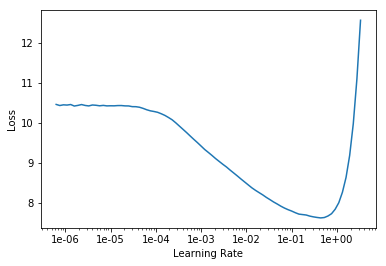

In [32]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,5.816084,5.460348,0.233318,00:22
2,5.294272,5.039455,0.259020,00:22
3,4.863846,4.685552,0.276862,00:22
4,4.491205,4.445933,0.294796,00:22
5,4.097989,4.235411,0.313614,00:22
6,3.581177,4.024802,0.337607,00:22
7,2.989625,3.821045,0.369734,00:22
8,2.480806,3.677303,0.398092,00:23
9,2.139157,3.619207,0.412943,00:23
10,1.969509,3.612619,0.415476,00:23


In [34]:
learn.save_encoder("encoder_5000_no_wiki")

## classification

In [35]:
data_clas = TextClasDataBunch.from_df("",vocab=learn.data.vocab, train_df=train, valid_df=valid, test_df=data_frame["test"],
                                      text_cols=["text"], label_cols=["label"], bs=24)
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_class.load_encoder("encoder_5000_no_wiki")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


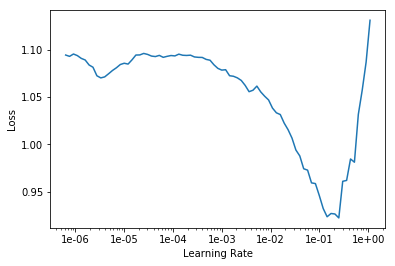

In [36]:
learn_class.lr_find()
learn_class.recorder.plot()

In [37]:
learn_class.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.611872,0.457030,0.810096,00:21
2,0.529961,0.464651,0.819231,00:19
3,0.483209,0.429004,0.821635,00:19


In [38]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(4, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.491698,0.393342,0.836538,00:22
2,0.470319,0.354650,0.854808,00:23
3,0.397737,0.356091,0.864423,00:24
4,0.356830,0.353884,0.867788,00:23


In [47]:
# learn_class.load("stap_1133")

In [48]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(4, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.318466,0.347586,0.866346,00:36
2,0.312002,0.364083,0.865865,00:36
3,0.296440,0.349804,0.881250,00:33
4,0.275528,0.352592,0.878846,00:36


In [49]:
learn_class.unfreeze()
learn_class.fit_one_cycle(10, slice(3e-5,3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.300816,0.353847,0.872596,00:47
2,0.307399,0.350120,0.874519,00:44
3,0.308392,0.362863,0.875962,00:42
4,0.277146,0.361560,0.871635,00:43
5,0.274253,0.329293,0.883654,00:42
6,0.311343,0.343816,0.883654,00:43
7,0.261273,0.327140,0.885096,00:43
8,0.244768,0.335125,0.887500,00:46
9,0.272952,0.333279,0.885096,00:45
10,0.267415,0.333456,0.884135,00:43


In [53]:
# learn_class.fit_one_cycle(20, slice(7e-5,7e-4), moms=(0.8,0.7))

In [54]:
p = learn_class.get_preds(ds_type = DatasetType.Test, ordered=True)
results = list(map(int, data_frame["test"]["label"].values)) == np.argmax(p[0].numpy(), axis=1)
results.sum() / len(p[1])

0.8890625

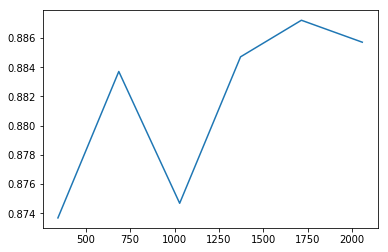

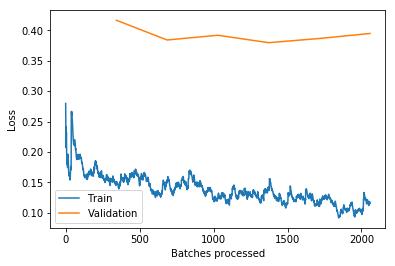

In [263]:
learn_class.recorder.plot_metrics()
learn_class.recorder.plot_losses()

## without dictionary limit

## language model

In [55]:
data_lm = (TextList.from_df(dataframe, cols=["text"])
            .random_split_by_pct(0.2)
            .label_for_lm()           
            .databunch(bs=24))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


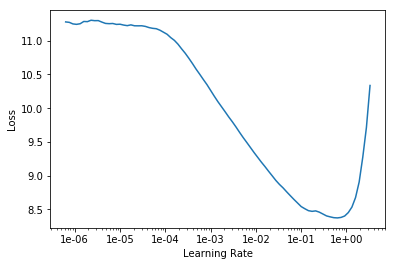

In [56]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [57]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.443810,5.936740,0.191285,00:24
2,5.921845,5.535961,0.222009,00:24
3,5.407600,5.101946,0.247115,00:24
4,4.911988,4.811228,0.261920,00:24
5,4.350749,4.571739,0.287622,00:24
6,3.777262,4.298264,0.317537,00:24
7,3.082404,4.086438,0.347985,00:24
8,2.510896,3.929323,0.376801,00:24
9,2.124378,3.856831,0.393010,00:24
10,2.013098,3.847392,0.395849,00:24


In [58]:
learn.save_encoder("encoder_9000_no_wiki")

## classification

In [59]:
data_clas = TextClasDataBunch.from_df("",vocab=learn.data.vocab, train_df=train, valid_df=valid, test_df=data_frame["test"],
                                      text_cols=["text"], label_cols=["label"], bs=24)
learn_class = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_class.load_encoder("encoder_9000_no_wiki")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


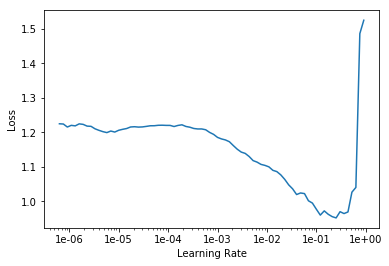

In [60]:
learn_class.lr_find()
learn_class.recorder.plot()

In [61]:
learn_class.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.590984,0.498156,0.785577,00:19
2,0.493350,0.541837,0.811538,00:19
3,0.498092,0.443190,0.821635,00:21


In [62]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(4, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.443724,0.413916,0.831250,00:24
2,0.474727,0.390350,0.841827,00:22
3,0.416990,0.339860,0.865865,00:23
4,0.359355,0.334811,0.863942,00:23


In [68]:
# learn_class.load("stap_1133")

In [69]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(4, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.370838,0.331409,0.859615,00:35
2,0.372160,0.316936,0.867308,00:33
3,0.313587,0.315037,0.871154,00:35
4,0.284782,0.313799,0.874519,00:35


In [70]:
learn_class.unfreeze()
learn_class.fit_one_cycle(10, slice(3e-5,3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.317268,0.326376,0.868269,00:42
2,0.292736,0.328587,0.868269,00:46
3,0.310566,0.326939,0.875962,00:45
4,0.300507,0.316180,0.875481,00:43
5,0.291316,0.317088,0.875962,00:43
6,0.281407,0.308271,0.879808,00:43
7,0.292559,0.331028,0.878365,00:47
8,0.259933,0.324692,0.882212,00:45
9,0.263067,0.307823,0.879327,00:46
10,0.262746,0.308775,0.881731,00:43


In [72]:
learn_class.fit_one_cycle(10, slice(3e-5,3e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.274074,0.310148,0.879327,00:42
2,0.251707,0.336043,0.875000,00:44
3,0.256384,0.313696,0.883173,00:44
4,0.253849,0.315391,0.887500,00:43
5,0.265981,0.310089,0.887500,00:43
6,0.301654,0.342679,0.886058,00:47
7,0.226032,0.301160,0.889423,00:45
8,0.253604,0.307639,0.891827,00:46
9,0.254984,0.306968,0.890865,00:46
10,0.234008,0.322001,0.890865,00:44


In [73]:
p = learn_class.get_preds(ds_type = DatasetType.Test, ordered=True)
results = list(map(int, data_frame["test"]["label"].values)) == np.argmax(p[0].numpy(), axis=1)
results.sum() / len(p[1])

0.895703125